<a href="https://colab.research.google.com/github/Teeradol/scas/blob/master/Risk_pricing_using_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
## Import library
import pandas as pd
import numpy as np
from keras.layers import Input, Embedding, LSTM, Dense, Reshape, concatenate
from keras.models import Model
from keras.utils.vis_utils import model_to_dot
from sklearn.model_selection import train_test_split
from IPython.display import SVG
%matplotlib inline

import tensorflow as tf


In [13]:
## Import data
link = 'http://www.statsci.org/data/general/motorins.txt'
df = pd.read_csv(link, sep = '\t')

## Calculated fields
df['frequency'] = df['Claims'] / df['Insured']

df['severity'] = df['Payment'] / df['Claims']
df['severity'] = df['severity'].fillna(0)

df['risk_premium'] = df['Payment'] / df['Insured']

df.head()

,Kilometres,Zone,Bonus,Make,Insured,Claims,Payment,frequency,severity,risk_premium
0,1,1,1,1,455.13,108,392491,0.237295,3634.175926,862.371191
1,1,1,1,2,69.17,19,46221,0.274686,2432.684211,668.223218
2,1,1,1,3,72.88,13,15694,0.178375,1207.230769,215.340285
3,1,1,1,4,1292.39,124,422201,0.095946,3404.846774,326.682348
4,1,1,1,5,191.01,40,119373,0.209413,2984.325000,624.956809


In [15]:
## Data Exploratory
df.shape
df.isnull().sum(axis = 0)


Kilometres      0
Zone            0
Bonus           0
Make            0
Insured         0
Claims          0
Payment         0
frequency       0
severity        0
risk_premium    0
dtype: int64

In [19]:
## Spliting training and testing dataset
train, test = train_test_split(df, test_size = 0.2, random_state = 12345)

## Calculate KPIs for dataset
total = train.loc[:, ['Insured', 'Claims', 'Payment']].agg('sum')
train_avg_frequency = total['Claims'] / total['Insured']
train_avg_severity = total['Payment'] / total['Claims']
train_avg_riskpremium = total['Payment'] / total['Insured']

print("Frequency is " + str(train_avg_frequency) + " Severity is " + str(train_avg_severity) + " Risk premium is " + str(train_avg_riskpremium))

Frequency is 0.04749109486158422 Severity is 4959.405313081085 Risk premium is 235.52758818057862


In [0]:
## Embeddings
zone_input = Input(shape = (1,), name = 'zone_input')
make_input = Input(shape = (1,), name = 'make_input')

zone_embedding = Embedding(output_dim=2, input_dim=7)(zone_input) 
zone_embedding = Reshape(target_shape=(2,))(zone_embedding) 

make_embedding = Embedding(output_dim=2, input_dim=9)(make_input) 
make_embedding = Reshape(target_shape=(2,))(make_embedding)

kilometres_input = Input(shape = (1,), name = 'kilometres_input')
bonus_input = Input(shape = (1,), name = 'bonus_input')

x = concatenate([zone_embedding, make_embedding, kilometres_input, bonus_input])

In [29]:
print(x)

Tensor("concatenate_1/concat:0", shape=(?, 6), dtype=float32)


In [0]:
## Dense layers
x = Dense(64, activation='relu')(x) 
x = Dense(64, activation='relu')(x) 
x = Dense(64, activation='relu')(x)


In [0]:
## Output
frequency_output = Dense(1, activation='relu', name='frequency')(x) 
severity_output = Dense(1, activation='relu', name='severity')(x) 
risk_premium_output = Dense(1, activation='relu', name='risk_premium')(x)

In [0]:
## Model Definition
model = Model(inputs=[zone_input, make_input, kilometres_input, bonus_input], outputs=[frequency_output, severity_output, risk_premium_output])


In [0]:
model.compile(optimizer='adam', loss={'risk_premium': 'mean_squared_error', 'frequency': 'poisson', 'severity': 'mean_squared_logarithmic_error'}, loss_weights={'risk_premium': 1.0, 'frequency': 1.0, 'severity': 1.0})


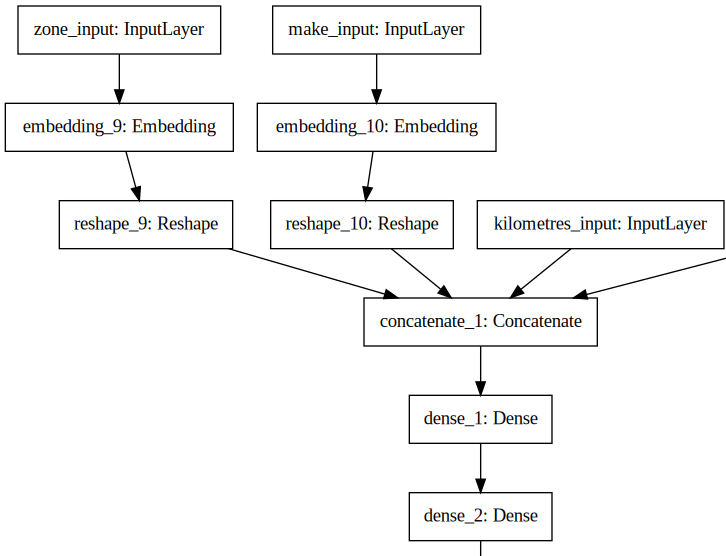

In [35]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [38]:
	def InputDataTransformer(x):
    return {'kilometres_input': (x.Kilometres.values - 1) / 5, 'zone_input': x.Zone.values - 1,
            'bonus_input': (x.Bonus.values - 1) / 7, 'make_input': x.Make.values - 1}

model.fit(InputDataTransformer(train), {'frequency': train.frequency.values / train_avg_frequency,
                                        'severity': train.severity.values / train_avg_severity,
                                        'risk_premium': train.risk_premium.values / train_avg_riskpremium}, 
          sample_weight={'frequency': train.Insured.values, 'severity': train.Claims.values, 'risk_premium': train.Insured.values}, 
          epochs=40, batch_size=32)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/40





1745/1745 [==============================] - 1s 657us/step - loss: 3023.8954 - frequency_loss: 1895.2338 - severity_loss: 32.3482 - risk_premium_loss: 1096.3135
Epoch 2/40
1745/1745 [==============================] - 0s 74us/step - loss: 1649.8412 - frequency_loss: 1161.2765 - severity_loss: 32.0999 - risk_premium_loss: 456.4648
Epoch 3/40
1745/1745 [==============================] - 0s 72us/step - loss: 1338.2147 - frequency_loss: 1058.5420 - severity_loss: 32.9130 - risk_premium_loss: 246.7597
Epoch 4/40
1745/1745 [==============================] - 0s 76us/step - loss: 1259.4296 - frequency_loss: 1031.1417 - severity_loss: 32.0424 - risk_premium_loss: 196.2455
Epoch 5/40
1745/1745 [==============================] - 0s 73us/step - loss: 1210.8152 - frequency_loss: 1011.4391 - severity_loss: 32.3905 - risk_premium_loss: 166.9856
Epoch 6/40
1745/1745 [========================

In [0]:
def predict_and_plot(df, train_average_frequency, train_average_risk_premium):
  model_frequency, model_severity, model_risk_premium = model.predict(InputDataTransformer(df))
  # Reverse the normalisation
  # Score, sort by lowest to higher
  df_new = df.assign(model_frequency = model_frequency * train_average_frequency, 
7
model_risk_premium = model_risk_premium * train_average_risk_premium) \
8
.assign(model_payment = lambda x: x.model_risk_premium * x.Insured,
9
model_claim_count = lambda x: x.model_frequency * x.Insured) \
10
.sort_values(by=['model_frequency']) \
11
.assign(model_claim_count_band = lambda x: np.floor(x.model_claim_count.cumsum() / x.model_claim_count.agg('sum') * 10) / 10) \
12
.sort_values(by=['model_risk_premium']) \
13
.assign(model_payment_band = lambda x: np.floor(x.model_payment.cumsum() / x.model_payment.agg('sum') * 10) / 10)
14
 
15
# Summarise and plot frequency by weighted decile rank
16
df_new.loc[:,['model_claim_count_band', 'Insured', 'Claims', 'model_claim_count']] \
17
.groupby('model_claim_count_band') \
18
.agg('sum') \
19
.assign(model_frequency = lambda x: x.model_claim_count / x.Insured,
20
actual_frequency = lambda x: x.Claims / x.Insured) \
21
.loc[:,['model_frequency', 'actual_frequency']] \
22
.plot.bar()
23
 
24
# Summarise and plot risk premium by weighted decile rank
25
df_new.loc[:,['model_payment_band', 'Insured', 'Payment', 'model_payment']] \
26
.groupby('model_payment_band') \
27
.agg('sum') \
28
.assign(model_risk_premium = lambda x: x.model_payment / x.Insured,
29
actual_risk_premium = lambda x: x.Payment / x.Insured) \
30
.loc[:,['model_risk_premium', 'actual_risk_premium']] \
31
.plot.bar()
32
 
33
return df_new
